# How to create a highly engaged reddit post?

# Executive Summary

This report provides an analysis, evaluation and suggestion for the question - How to create a highly-engaged reddit post.  
  
This is a binary classification and inferences problem based on two points:  
1. Target classification: The goal is to increase the reddit post engagement rate, which can be measured by the number of comments in the post. By comparing the comment number for each post with the median number of comments, I can build a binary classification model to learn and predict the high engagement post.  
2. Features inferences: To answer the “How to” question, the features I’m looking for in this problem will be the drivers of engagement and can be measured by the feature importance of this classification model.
  
To solve the problem, my workflow includes three parts:  
1. Models: Build classification models that are possible to interpret the importance of features (e.g. KNN can’t be used) and choose one with a highest test score of accuracy.
2. Inferences: Analyze the result of features (coefficient / feature importance) and find the most important features that can be used to drive more engagement for reddit post.
3. Suggestions: Give specific suggestions to answer the how to question.  
  
Here are some findings I got from the classification modeling and the natural language processing:  
1. The top influencers of the post engagement are: 
    - Upvotes
    - Duration of posting
    - Subreddit subscribers
    - Post type
    - Stickied
    - Subreddit name
2. Text post get a higher performance on the engagement matrix: 
    - It takes shorter time to become a highly engaged post
    - It gets more comments per post on average
    - It gets more comments per hour than other types of post
    - It has a bigger chance to become a highly engaged post
    - It gets more comments per upvote on average
3. Keywords in comments shows the general topic in this subreddit  
  
Based on the findings, I made some suggestions on how to create a highly-engaged reddit post.
1. Post position: Post in the subreddits that have higher number of subscribers
2. Post type: Use text post (aka self post) is a better choice
3. Post content: Focus on the specific keywords in the comments of subreddit
  
Moving forward, I’m going to focus on these studies below: 
1. Explore the driver of text post (self post) engagement: 
    - Test post content: is there any specific words / phrases in the content driving engagement?
    - Test post title: does the title matter for text post? will it be more important than other types of post?
2. Tune and improve my model to increase the accuracy score
3. Collect more data and consider about finding new features 
4. Thoroughly Interpret model result and give more recommendations


# 1. Define the problem
### Problem: How to create a highly-engaged reddit post?
- Target: Engagement -> number of comment -> high / low (threshold: median)
- Features: Drivers of engagement -> highly related matrix (measure: feature importance)

### Problem Type: Classification & Inferences

### My Workflow:
- Models: Build classification models that are possible to interpret the importance of features (e.g. KNN can’t be used) and choose one with a highest test score of accuracy.
- Inferences: Analyze the result of features (coefficient / feature importance) and find the most important features that can be used to drive more engagement for reddit post.
- Suggestions: Give specific suggestions to answer the how to question.

# 2. Obtain the data
### Scraped thread info from reddit.com by sending GET requests
- Get all information listed in the homepage (87 columns total)
- Get 3 pieces of data from different time of the day - at 11pm, 7am and 3pm (5000 rows with duplicates each time)
- Total 87 columns and 15,000 rows data as a starting point

### Scraped comments from r/CringeAnarchy and r/funny subreddit pages using Python reddit API wrapper PRAW (code is on the last part)
- For each subreddit, go through top 1000 posts and top 10 comments (without any replies) for each post and pack the comments together for each post (1000 rows for each subreddit)
- Get number of comments / ups / title / name of post for further analysis


In [42]:
import requests
import json
import time
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, roc_curve
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from scipy import stats
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [133]:
# test the request response
url = "http://www.reddit.com/hot.json"
headers = {'User-agent': 'caroldxx007'}
res = requests.get(url, headers=headers)
res.status_code

200

In [3]:
# explore the json dataset
the_json = res.json()
print(sorted(the_json.keys()))
print(sorted(the_json['data'].keys()))

['data', 'kind']
['after', 'before', 'children', 'dist', 'modhash']


In [5]:
# grab 5000 rows of data at Thursday around 11 pm
posts = []
after = None
print(time.time())
for i in range(200):
    if after == None:
        params = {}
    else:
        params = {'after': after}
    url = 'https://www.reddit.com/hot.json'
    res = requests.get(url, params=params, headers=headers)
    if res.status_code == 200:
        the_json = res.json()
        post_data = the_json['data']['children']
        after = the_json['data']['after']
        for p in post_data:
            p_total = p['data']
            p_total['current_time'] = time.time()
            p_total['duration'] = p_total['current_time'] - p_total['created_utc']
            posts.append(p_total)
    else:
        print(res.status_code)
        break
    time.sleep(1)
df = pd.DataFrame(posts)
df.to_csv('data_night.csv', index=False)
print('finished')

1527821738.7688441
finished


In [134]:
# grab 5000 rows of data at Friday around 7 am
posts = []
after = None
print(time.time())
for i in range(200):
    if after == None:
        params = {}
    else:
        params = {'after': after}
    url = 'https://www.reddit.com/hot.json'
    res = requests.get(url, params=params, headers=headers)
    if res.status_code == 200:
        the_json = res.json()
        post_data = the_json['data']['children']
        after = the_json['data']['after']
        for p in post_data:
            p_total = p['data']
            p_total['current_time'] = time.time()
            p_total['duration'] = p_total['current_time'] - p_total['created_utc']
            posts.append(p_total)
    else:
        print(res.status_code)
        break
    time.sleep(1)
df = pd.DataFrame(posts)
df.to_csv('data_morning.csv', index=False)
print('finished')

1527850913.145735
finished


In [159]:
# grab 5000 rows of data at Friday around 3 pm
posts = []
after = None
print(time.time())
for i in range(200):
    if after == None:
        params = {}
    else:
        params = {'after': after}
    url = 'https://www.reddit.com/hot.json'
    res = requests.get(url, params=params, headers=headers)
    if res.status_code == 200:
        the_json = res.json()
        post_data = the_json['data']['children']
        after = the_json['data']['after']
        for p in post_data:
            p_total = p['data']
            p_total['current_time'] = time.time()
            p_total['duration'] = p_total['current_time'] - p_total['created_utc']
            posts.append(p_total)
    else:
        print(res.status_code)
        break
    time.sleep(1)
df = pd.DataFrame(posts)
df.to_csv('data_afternoon.csv', index=False)
print('finished')

1527879946.5197282
finished


# 3. Explore the data
### Build a function to clean up the data in terms of some aspects below:  
  
1. Drop duplicates (by name)  
2. Go through the data info and choose relative features (manually) 
    - required features: title, subreddit, duration
    - add features: post_hint, ups, subreddit_subscribers, spoiler, stickied, over_18 
    - predictor: num_comments
3. Deal with NA values  
4. Check data types / relationship of each features and do feature engineering  
    - Combine similar features together : use is_self to add missing text post category information in post_hint
    - Create dummy variables: subreddit, spoiler, stickied, over_18 
    - Use CountVectorizer to create features (words) to deal with string variable: title
    - Map num_comments to binary value 
        - 0: low engagement, num_comments < median
        - 1: high engagement, num_comments >= median
5. Train / test dataset split (0.85, 0.15)

In [160]:
# get data from the data file
df_morning = pd.read_csv('data_morning.csv')
df_afternoon = pd.read_csv('data_afternoon.csv')
df_night = pd.read_csv('data_night.csv')
df = pd.concat([df_morning, df_afternoon, df_night], axis=0)
df.shape

(15000, 87)

In [231]:
df.post_hint.unique()

array(['image', 'link', 'hosted:video', nan, 'rich:video', 'self',
       'video'], dtype=object)

In [161]:
df.info()
# drop duplicates by name
# duration, subreddit, title
# created_utc, is_self (-> post_hint), is_video (video + hosted:video), over_18, post_hint, ups, subreddit_subscribers
# selftext (is_self == true but not all have selftext, some only have title， for selfpost study), spoiler, stickied
# num_comments

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 4999
Data columns (total 87 columns):
approved_at_utc             0 non-null float64
approved_by                 0 non-null float64
archived                    15000 non-null bool
author                      15000 non-null object
author_cakeday              60 non-null object
author_flair_css_class      0 non-null float64
author_flair_template_id    0 non-null float64
author_flair_text           0 non-null float64
banned_at_utc               0 non-null float64
banned_by                   0 non-null float64
can_gild                    15000 non-null bool
can_mod_post                15000 non-null bool
clicked                     15000 non-null bool
contest_mode                15000 non-null bool
created                     15000 non-null float64
created_utc                 15000 non-null float64
crosspost_parent            396 non-null object
crosspost_parent_list       396 non-null object
current_time                

In [45]:
df['num_comments'].median()

19.0

(0, 200)

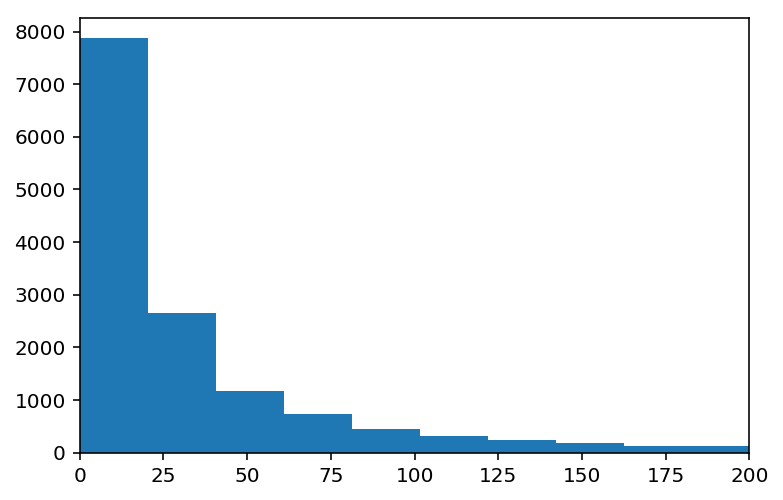

In [11]:
plt.hist(df['num_comments'],bins=1000)
plt.xlim([0,200])

In [162]:
def data_clean(df):
    # choose 9 features and 1 prediction but need 12 columns first to do feature engineering  
    df1 = df[['duration','subreddit','title', 'is_self', 
          'over_18', 'post_hint', 'spoiler', 'stickied', 'ups','subreddit_subscribers','num_comments','name']]
    
    # remove duplicates
    df1.drop_duplicates(subset='name',inplace=True)
    # drop column 'name'
    df1.drop('name',axis=1,inplace=True)
    
    # some selfpost doesn't have a post type, this can be fixed
    mask1 = (df1['is_self'] == True) & (df1['post_hint'].isnull() == True)
    df1.loc[mask1,'post_hint'] = 'self'
    # other post that has post_hint = NA, change it to ''
    mask2 = df1['post_hint'].isnull() == True
    df1.loc[mask2,'post_hint'] = ''  
    # drop column 'is_self' because we already use this info and put it into the 'post_hint' column
    df1.drop('is_self',axis=1,inplace=True)
    
    # map boolean objects to 0 and 1
    df1[['over_18','spoiler','stickied']] = df1[['over_18','spoiler','stickied']].astype(int)
    
    # create prediction column as 'comments' and set 0 as lower than *median*
    # 1 as higher (or equal to) *median* comments 
    df1['comments'] = 0
    mask3 = df1['num_comments']>=df1['num_comments'].median()
    df1.loc[mask3,'comments'] = 1  
    # drop 'num_comments' column
    df1.drop('num_comments',axis=1,inplace=True)
    
    # create dummy value for 'subreddit' and 'post_hint' columns
    df1 = pd.get_dummies(df1,drop_first=True,columns=['post_hint','subreddit'])
    
    # split features and prediction
    X = df1[[col for col in df1.columns if col != 'comments']]
    y = df1['comments']
    
    # split train / test dataset and use CountVectorizer to deal with the title strings 
    # (fit and transform training dataset, only transform test dataset)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.15)
    
    cvec = CountVectorizer(stop_words="english")
    X_train_title = cvec.fit_transform(X_train['title'])
    X_test_title = cvec.transform(X_test['title'])
    features_name = []
    for i in cvec.get_feature_names():
        i = 'title_' + i
        features_name.append(i)
    X_train_title_df = pd.DataFrame(X_train_title.toarray(),columns=features_name,index=X_train.index)
    X_test_title_df = pd.DataFrame(X_test_title.toarray(),columns=features_name,index=X_test.index)
    
    # drop 'title' column and concat the title features and othe features together
    X_train.drop('title',axis=1,inplace=True)
    X_test.drop('title',axis=1,inplace=True)
    X_train_clean = pd.concat([X_train,X_train_title_df],axis=1)
    X_test_clean = pd.concat([X_test,X_test_title_df],axis=1)
    
    print('X_train shape: ', X_train_clean.shape)
    print('X_test shape: ', X_test_clean.shape)

    #return a dictionary of train and test dataset
    data = {'features': [X_train_clean, X_test_clean], 'target':[y_train, y_test], 'total':df1}
    return data 

In [163]:
clean_data = data_clean(df)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarn

X_train shape:  (9343, 18209)
X_test shape:  (1649, 18209)


# 4. Model with data & Evaluation
### Create models using Pipeline and tune models using GridSearchCV:
1. Model with data from Mreddit.com homepage (morning + afternoon + night)
    - check all features: Build models using pipeline and tune them using GridsearchCV
        - Random Forest
        - Logistic Regression
        - MultinomialNB  
    - check the top 5 features only
    - check the subreddit feature only
    - check the title feature only 
       
2. Explore comments on the top subreddits "CringeAnarchy" and "funny"
    - Use Praw to get comments from reddit API
        - Explore comments on one top subreddit "CringeAnarchy", which is for "all organized alt right trolls"
        - Explore comments on one top subreddit "funny", which has a big number of subscribers and more generic
    - Build a model (Random Forest) to analyze which words are important in the comment section of the top posts that drive more engagement
    - Compare the keywords

### 1) Model with total data (morning + afternoon + night)

#### Model with all data & all selected features

In [23]:
# baseline accuracy
clean_data['total']['comments'].value_counts(normalize = True)

1    0.500455
0    0.499545
Name: comments, dtype: float64

- Build Random Forest Classification model and evaluate

In [26]:
# build a Random Forest Classification model using pipeline
X_train = clean_data['features'][0]
X_test = clean_data['features'][1]
y_train = clean_data['target'][0]
y_test = clean_data['target'][1]

pip = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
params = {
    'rf__n_estimators':[10,20,30],
    'rf__max_features': ["auto","sqrt","log2"],
    'rf__max_depth': [None,10,20]
}
gs = GridSearchCV(pip,param_grid=params)
gs.fit(X_train,y_train)
print('best cv score', gs.best_score_)
print('best paramas', gs.best_params_)
print('test score', gs.score(X_test, y_test))

best cv score 0.7651717863641229
best paramas {'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__n_estimators': 30}
test score 0.7847180109157065


In [27]:
# feature importance of RandomForest
coef = pd.DataFrame(gs.best_estimator_.steps[0][1].feature_importances_,
                    index=X_train.columns,
                    columns=['feature_importances'])
coef.sort_values(by='feature_importances',ascending=False)

,feature_importances
ups,0.127334
duration,0.085101
subreddit_subscribers,0.045274
post_hint_image,0.019235
post_hint_self,0.012826
post_hint_link,0.005826
subreddit_funny,0.002486
stickied,0.002292
subreddit_CringeAnarchy,0.002155
subreddit_FortNiteBR,0.001822


In [28]:
# create a confusion matrix
y_hat = gs.predict(X_test)
confusion_matrix(y_test,y_hat)

array([[683, 141],
       [214, 611]])

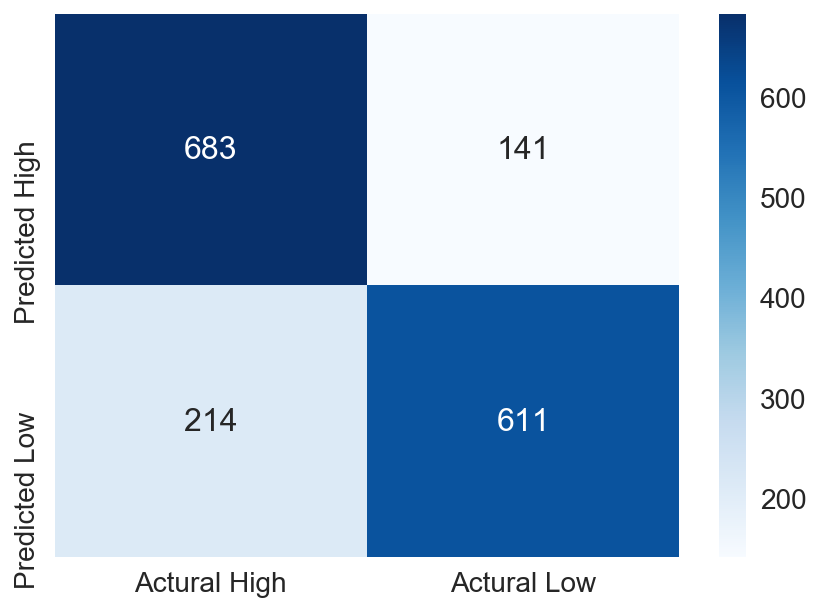

In [138]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
cm = ([[683, 141],
       [214, 611]])
df_cm = pd.DataFrame(cm, index=['Predicted High', 'Predicted Low'], columns = ['Actural High', 'Actural Low'])
sns.set(font_scale=1.4)
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, cmap='Blues', fmt='g', annot=True, annot_kws={"size": 16})

- Build Logistic Regression model and evaluate

In [24]:
# build a logistic regression model using pipeline
X_train = clean_data['features'][0]
X_test = clean_data['features'][1]
y_train = clean_data['target'][0]
y_test = clean_data['target'][1]

pip = Pipeline([
    ('ss', StandardScaler()), 
    ('lr', LogisticRegression())
])
params = {
    'lr__penalty':['l1','l2'],
    'lr__C':[0.1,0.5,0.9]
}
gs = GridSearchCV(pip,param_grid=params)
gs.fit(X_train,y_train)
print('best cv score', gs.best_score_)
print('best paramas', gs.best_params_)
print('test score', gs.score(X_test, y_test))

best cv score 0.7453708658889008
best paramas {'lr__C': 0.1, 'lr__penalty': 'l1'}
test score 0.7653123104912067


In [25]:
# coefficients of LogReg
coef = pd.DataFrame(gs.best_estimator_.steps[1][1].coef_[0],index=X_train.columns,columns=['coefficients'])
coef['coef_abs'] = coef['coefficients'].abs()
coef.sort_values(by='coef_abs',ascending=False)

,coefficients,coef_abs
ups,9.950712,9.950712
duration,1.388818,1.388818
post_hint_self,0.624676,0.624676
post_hint_image,-0.602264,0.602264
subreddit_subscribers,0.357136,0.357136
subreddit_CringeAnarchy,0.296196,0.296196
subreddit_FortNiteBR,0.249492,0.249492
subreddit_teefies,-0.240033,0.240033
subreddit_rupaulsdragrace,0.239435,0.239435
subreddit_LiverpoolFC,0.216965,0.216965


- MultinomialNB Classification model and evaluate

In [54]:
# build a MultinomialNB Classification model using pipeline
X_train = clean_data['features'][0]
X_test = clean_data['features'][1]
y_train = clean_data['target'][0]
y_test = clean_data['target'][1]

pip = Pipeline([
    ('mnb', MultinomialNB())
])
params = {'mnb__alpha':[0,0.5,1]}
gs = GridSearchCV(pip,param_grid=params)
gs.fit(X_train,y_train)
print('best cv score', gs.best_score_)
print('best paramas', gs.best_params_)
print('test score', gs.score(X_test, y_test))

/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


best cv score 0.5427592850262228
best paramas {'mnb__alpha': 0}
test score 0.5476046088538509


In [55]:
# coefficients of MultinomialNB
coef = pd.DataFrame(gs.best_estimator_.steps[0][1].coef_[0],index=X_train.columns,columns=['coefficients'])
coef['coef_abs'] = coef['coefficients'].abs()
coef.sort_values(by='coef_abs',ascending=False)

,coefficients,coef_abs
title_𝔗𝔥𝔢,-46.158008,46.158008
title_popcorn,-46.158008,46.158008
title_cites,-46.158008,46.158008
title_cited,-46.158008,46.158008
title_popeyes,-46.158008,46.158008
title_poppin,-46.158008,46.158008
title_circumcision,-46.158008,46.158008
title_circular,-46.158008,46.158008
title_circuit,-46.158008,46.158008
title_popsicle,-46.158008,46.158008


- Random Forest Classification performs better, **fit whole dataset and build the model**

In [175]:
# build a Random Forest Classification model using pipeline (fit all data)
X_train = clean_data['features'][0]
X_test = clean_data['features'][1]
y_train = clean_data['target'][0]
y_test = clean_data['target'][1]
X_total = pd.concat([X_train,X_test])
y_total = pd.concat([y_train,y_test])

pip = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
params = {
    'rf__n_estimators':[10,20,30],
    'rf__max_features': ["auto","sqrt","log2"],
    'rf__max_depth': [None,10,20]
}
gs = GridSearchCV(pip,param_grid=params)
gs.fit(X_total,y_total)
print('best cv score', gs.best_score_)
print('best paramas', gs.best_params_)

best cv score 0.7695596797671034
best paramas {'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__n_estimators': 30}


In [176]:
# feature importance of RandomForest
features = pd.DataFrame(gs.best_estimator_.steps[0][1].feature_importances_,
                    index=X_train.columns,
                    columns=['feature_importances'])
features = features.sort_values(by='feature_importances',ascending=False)
features

,feature_importances
ups,0.147214
duration,0.077937
subreddit_subscribers,0.048578
post_hint_image,0.020782
post_hint_self,0.012919
post_hint_link,0.004694
stickied,0.002130
subreddit_FortNiteBR,0.002075
subreddit_funny,0.001987
subreddit_gaming,0.001761


#### Interpret my model using chart and table!

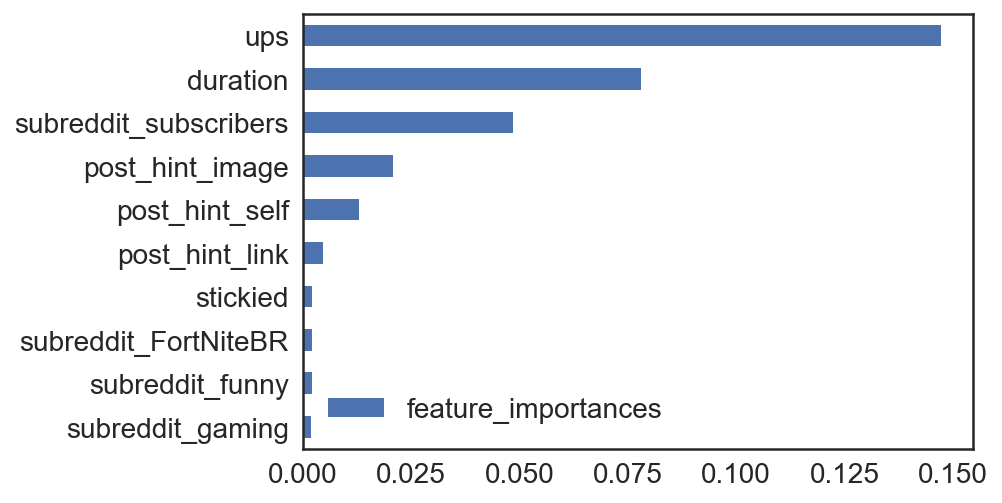

In [182]:
sns.set_style("white")
features.iloc[:10,:].sort_values(by='feature_importances',ascending=True).plot.barh()

In [269]:
import datetime
from time import gmtime, strftime
total_df = clean_data['total']
df1 = df.drop_duplicates(subset='name')
mask = (total_df.index == df1.index)
total_df.loc[mask,'num_comments'] = df1['num_comments']
total_df['post_type'] = 1*total_df['post_hint_image']+2*total_df['post_hint_self']+3*total_df['post_hint_link']
total_df['post_type'] = total_df['post_type'].map({0:'video',1:'image',2:'textpost',3:'linkpost'})
total_df['engagement'] = total_df['comments'].map({0:'low',1:'high'})
gb = total_df.groupby(['engagement','post_type'])
measure_df = pd.DataFrame(gb[['ups','duration','subreddit_subscribers','num_comments']].mean())
measure_df['count'] = gb.size()
measure_df['total_percentage'] = (measure_df['count']/(measure_df['count'].sum())).map(lambda x: "{0:.2f}%".format(x * 100))
measure_df['num_comments_per_hour'] = (measure_df['num_comments'] / (measure_df['duration']/3600)).round(0).astype(int)
measure_df['duration'] = measure_df['duration'].map(lambda x: datetime.datetime.fromtimestamp(int(x)+18000).strftime('%H:%M:%S'))
measure_df['ups'] = measure_df['ups'].round(0).astype(int)
measure_df['subreddit_subscribers'] = measure_df['subreddit_subscribers'].round(0).astype(int)
measure_df['num_comments'] = measure_df['num_comments'].round(0).astype(int)
measure_df['comments_ups_ratio'] = measure_df['num_comments']/measure_df['ups']
measure_df['comments_ups_ratio'] = measure_df['comments_ups_ratio'].map(lambda x: "{0:.2f}%".format(x * 100))
measure_df

ups  duration  subreddit_subscribers  num_comments  \
engagement post_type                                                        
high       image      2843  12:20:16                1685358            95   
           linkpost   2635  10:40:20                3588051           161   
           textpost   1305  10:02:45                2803281           233   
           video      3344  11:38:29                3045657           147   
low        image       224  07:32:50                 705476             7   
           linkpost    168  06:26:29                1455313             7   
           textpost    109  05:58:35                2561648             8   
           video       173  07:02:51                 885400             8   

                      count total_percentage  num_comments_per_hour  \
engagement post_type                                                  
high       image       2891           26.30%                      8   
           linkpost    1177           10.71%                     15   
           textpost     878            7.99%                     23   
           video        555            5.05%                     13   
low        image       4034           36.70%                      1   
           linkpost     763            6.94%                      1   
           textpost     320            2.91%                      1   
           video        374            3.40%                      1   

                     comments_ups_ratio  
engagement post_type                     
high       image                  3.34%  
           linkpost               6.11%  
           textpost              17.85%  
           video                  4.40%  
low        image                  3.12%  
           linkpost               4.17%  
           textpost               7.34%  
           video                  4.62%

#### Model with all data & 5 top features only

In [23]:
# baseline accuracy
clean_data['total']['comments'].value_counts(normalize = True)

1    0.500455
0    0.499545
Name: comments, dtype: float64

- Build Random Forest Classification model and evaluate

In [164]:
# build a Random Forest Classification model using pipeline
X_train = clean_data['features'][0][['ups','duration','subreddit_subscribers','post_hint_image','post_hint_self']]
X_test = clean_data['features'][1][['ups','duration','subreddit_subscribers','post_hint_image','post_hint_self']]
y_train = clean_data['target'][0]
y_test = clean_data['target'][1]

pip = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
params = {
    'rf__n_estimators':[5,10],
    'rf__max_features': ["sqrt","log2"],
    'rf__max_depth': [5,10,20]
}
gs = GridSearchCV(pip,param_grid=params)
gs.fit(X_train,y_train)
print('best cv score', gs.best_score_)
print('best paramas', gs.best_params_)
print('test score', gs.score(X_test, y_test))

best cv score 0.7554318741303649
best paramas {'rf__max_depth': 5, 'rf__max_features': 'sqrt', 'rf__n_estimators': 5}
test score 0.7665251667677381


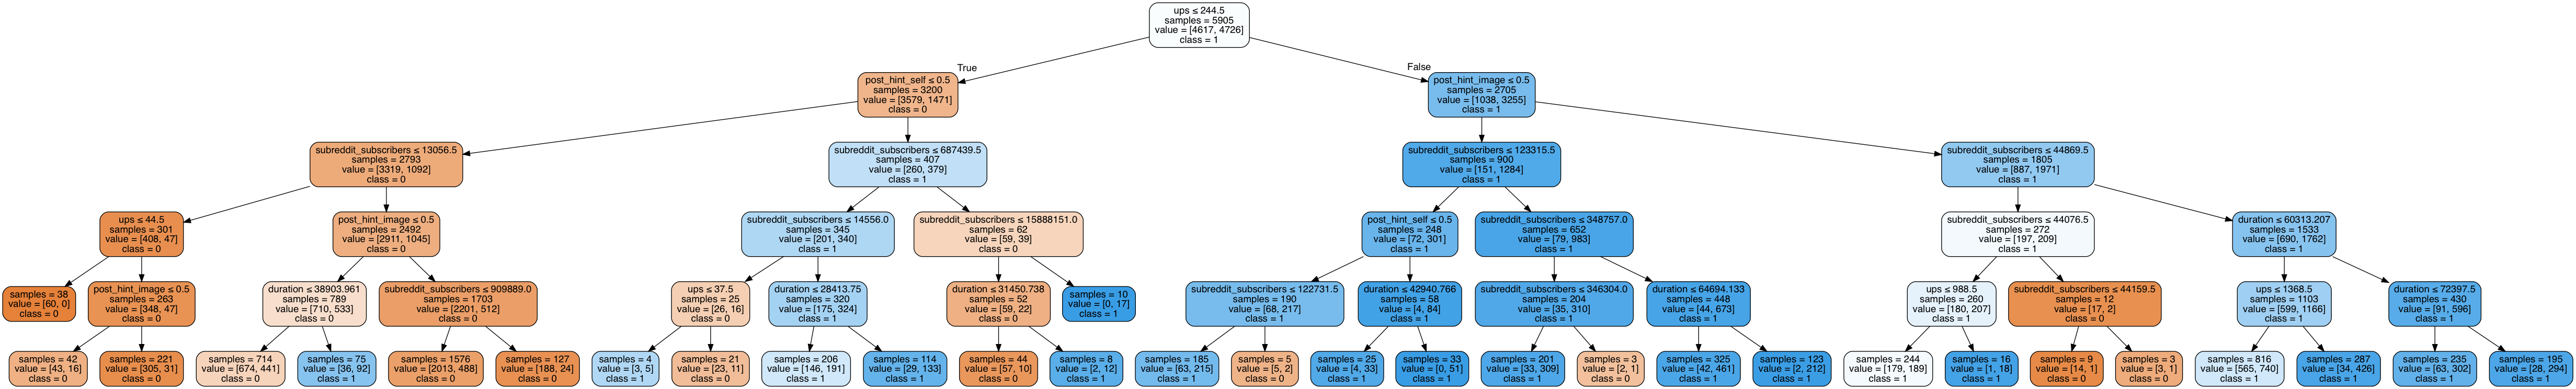

In [165]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image
import pydotplus

# make a variable to pretend to be a file
dot_data = StringIO()

# generate the tree (save it in the pretend file variable)
# uses a fitted decision tree (this time from the grid search)

export_graphviz(gs.best_estimator_.steps[0][1].estimators_[0],   # the fitted tree
                     out_file=dot_data, # the file variable
                     feature_names=X_train.columns,  # column names
                     class_names=['0','1'],     # target classes
                     filled=True,    # colors!
                     rounded=True,    # corners!
                     proportion=False,  # additional data!
                     impurity=False,    # additional data!
                     special_characters=True)  # prettier printing

# create the image from the tree data
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

# present the image
Image(graph.create_png())

In [166]:
# feature importance of RandomForest
top_feature_importances = pd.DataFrame(gs.best_estimator_.steps[0][1].feature_importances_,
                    index=X_train.columns,
                    columns=['feature_importances'])
top_feature_importances.sort_values(by='feature_importances',ascending=False)

,feature_importances
ups,0.579503
post_hint_image,0.149641
duration,0.149510
subreddit_subscribers,0.070286
post_hint_self,0.051060


In [168]:
# create a confusion matrix
top_y_hat = gs.predict(X_test)
confusion_matrix(y_test,top_y_hat)

array([[634, 190],
       [195, 630]])

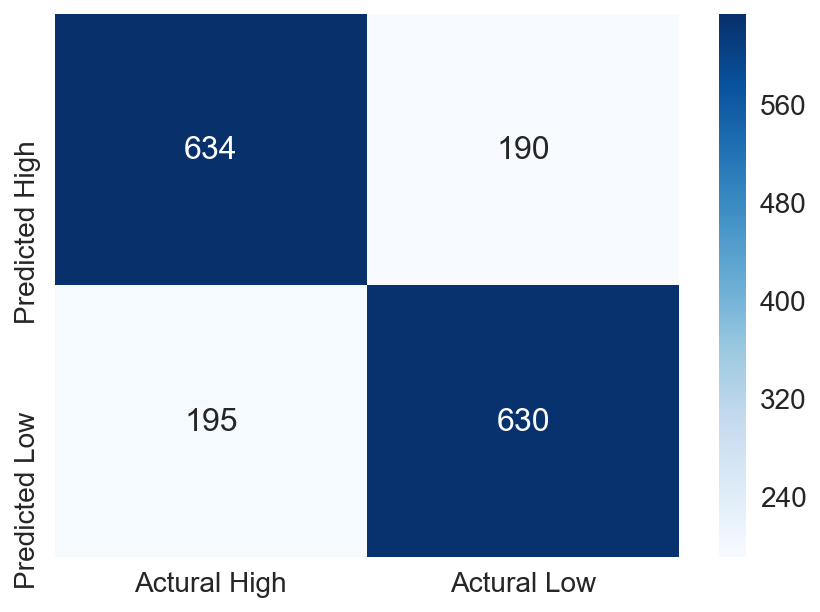

In [169]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
cm = ([[634, 190],
       [195, 630]])
df_cm = pd.DataFrame(cm, index=['Predicted High', 'Predicted Low'], columns = ['Actural High', 'Actural Low'])
sns.set(font_scale=1.4)
plt.figure(figsize = (7,5))
sns.heatmap(df_cm, cmap='Blues', fmt='g', annot=True, annot_kws={"size": 16})

#### Model with all data & subreddit feature only

In [270]:
def data_clean_subreddit(df):
    df1 = df[['subreddit','num_comments','name']]
    
    # remove duplicates
    df1.drop_duplicates(subset='name',inplace=True)
    # drop column 'name'
    df1.drop('name',axis=1,inplace=True)
    
    # create prediction column as 'comments' and set 0 as lower than *median*
    # 1 as higher (or equal to) *median* comments 
    df1['comments'] = 0
    mask3 = df1['num_comments']>=df1['num_comments'].median()
    df1.loc[mask3,'comments'] = 1  
    # drop 'num_comments' column
    df1.drop('num_comments',axis=1,inplace=True)
    
    # create dummy value for 'subreddit'feature
    df1 = pd.get_dummies(df1,drop_first=True,columns=['subreddit'])
    
    # split features and prediction
    X = df1[[col for col in df1.columns if col != 'comments']]
    y = df1['comments']
    
    # split train / test dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.15)

    #return a dictionary of train and test dataset
    data = {'features': [X_train, X_test], 'target':[y_train, y_test], 'total':df1}
    return data 

In [271]:
clean_data_subreddit = data_clean_subreddit(df)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is tryi

In [272]:
# build a Random Forest Classification model using pipeline (ONLY using the subreddit as a feature)
X_train = clean_data_subreddit['features'][0]
X_test = clean_data_subreddit['features'][1]
y_train = clean_data_subreddit['target'][0]
y_test = clean_data_subreddit['target'][1]

pip = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
params = {
    'rf__n_estimators':[10,20,30],
    'rf__max_features': ["auto","sqrt","log2"],
    'rf__max_depth': [None,10,20]
}
gs = GridSearchCV(pip,param_grid=params)
gs.fit(X_train,y_train)
print('best cv score', gs.best_score_)
print('best paramas', gs.best_params_)
print('test score', gs.score(X_test, y_test))

best cv score 0.6104035106496842
best paramas {'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__n_estimators': 30}
test score 0.6209824135839903


In [274]:
# feature importance of RandomForest
sub_feature_importances = pd.DataFrame(gs.best_estimator_.steps[0][1].feature_importances_,
                    index=X_train.columns,
                    columns=['feature_importances'])
# add subscribers into the dataframe
total_train = clean_data['features'][0]
subscribers=[]
subreddit=[]
for i in X_train.columns:
    subscriber=max(total_train[i]*total_train['subreddit_subscribers'])
    subscribers.append(subscriber)
    subreddit.append(i)
df_subscribers = pd.DataFrame(subscribers,index=subreddit)
sub_feature_importances['subscribers'] = df_subscribers

sub_feature_importances.sort_values(by='feature_importances',ascending=False)

,feature_importances,subscribers
subreddit_FortNiteBR,0.010790,656595
subreddit_funny,0.009471,19627164
subreddit_AskReddit,0.008997,19304138
subreddit_gaming,0.007842,18195370
subreddit_CringeAnarchy,0.007268,349850
subreddit_NintendoSwitch,0.005807,626768
subreddit_MMA,0.005307,534258
subreddit_aww,0.005242,17217470
subreddit_todayilearned,0.005178,18841886
subreddit_videos,0.004969,17810253


In [62]:
# create a confusion matrix
y_hat = gs.predict(X_test)
confusion_matrix(y_test,y_hat)

array([[424, 400],
       [225, 600]])

#### Model with all data & title feature only

In [68]:
def data_clean_title(df):
    df1 = df[['title','num_comments','name']]
    
    # remove duplicates
    df1.drop_duplicates(subset='name',inplace=True)
    # drop column 'name'
    df1.drop('name',axis=1,inplace=True)
    
    # create prediction column as 'comments' and set 0 as lower than *median*
    # 1 as higher (or equal to) *median* comments 
    df1['comments'] = 0
    mask3 = df1['num_comments']>=df1['num_comments'].median()
    df1.loc[mask3,'comments'] = 1  
    # drop 'num_comments' column
    df1.drop('num_comments',axis=1,inplace=True)
    
    # split features and prediction
    X = df1[[col for col in df1.columns if col != 'comments']]
    y = df1['comments']
    
    # split train / test dataset and use CountVectorizer to deal with the title strings 
    # (fit and transform training dataset, only transform test dataset)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.15)
    
    cvec = CountVectorizer(stop_words="english",ngram_range=(1,2))
    X_train_title = cvec.fit_transform(X_train['title'])
    X_test_title = cvec.transform(X_test['title'])
    features_name = []
    for i in cvec.get_feature_names():
        i = 'title_' + i
        features_name.append(i)
    X_train_title_df = pd.DataFrame(X_train_title.toarray(),columns=features_name,index=X_train.index)
    X_test_title_df = pd.DataFrame(X_test_title.toarray(),columns=features_name,index=X_test.index)
    
    # drop 'title' column and concat the title features and othe features together
    X_train.drop('title',axis=1,inplace=True)
    X_test.drop('title',axis=1,inplace=True)
    X_train_clean = pd.concat([X_train,X_train_title_df],axis=1)
    X_test_clean = pd.concat([X_test,X_test_title_df],axis=1)
    
    print(X_train_clean.shape)
    print(X_test_clean.shape)

    #return a dictionary of train and test dataset
    data = {'features': [X_train_clean, X_test_clean], 'target':[y_train, y_test], 'total':df1}
    return data

In [69]:
clean_data_title = data_clean_title(df)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is tryi

(9343, 53580)
(1649, 53580)


In [70]:
# build a Random Forest Classification model using pipeline (ONLY using the title as a feature)
X_train = clean_data_title['features'][0]
X_test = clean_data_title['features'][1]
y_train = clean_data_title['target'][0]
y_test = clean_data_title['target'][1]

pip = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
params = {
    'rf__n_estimators':[10,20,30],
    'rf__max_features': ["auto","sqrt","log2"],
    'rf__max_depth': [None,10,20]
}
gs = GridSearchCV(pip,param_grid=params)
gs.fit(X_train,y_train)
print('best cv score', gs.best_score_)
print('best paramas', gs.best_params_)
print('test score', gs.score(X_test, y_test))

best cv score 0.550572621213743
best paramas {'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__n_estimators': 30}
test score 0.5457853244390539


In [71]:
# feature importance of RandomForest
coef = pd.DataFrame(gs.best_estimator_.steps[0][1].feature_importances_,
                    index=X_train.columns,
                    columns=['feature_importances'])
coef.sort_values(by='feature_importances',ascending=False)

,feature_importances
title_2meirl4meirl,0.001442
title_games,0.001332
title_wait,0.001158
title_parents,0.001074
title_come,0.001065
title_support,0.001030
title_new,0.001006
title_away,0.000991
title_bike,0.000954
title_arm,0.000915


In [72]:
# create a confusion matrix
y_hat = gs.predict(X_test)
confusion_matrix(y_test,y_hat)

array([[594, 230],
       [519, 306]])

### 2) Explore comments on one top subreddit "CringeAnarchy" and "funny" and compare the results

In [30]:
! pip install praw

    100% |████████████████████████████████| 102kB 721kB/s a 0:00:01


#### Explore comments on one top subreddit "CringeAnarchy", which is for "all organized alt right trolls".

- use Praw to get comments from reddit API
- build a model to analyze which words are most popular in this subreddit that drove a higher number of comments / interactions and make the post a hot one.

In [137]:
import praw

reddit = praw.Reddit(client_id='rFsTUNOR5rvrjg',
                     client_secret='5FThX1bgAsJZapRLu20QMwBt-TU', password='1992d6q3',
                     user_agent='caroldxx007', username='CarolDxx')
subreddit = reddit.subreddit('CringeAnarchy')

# there are 2 sticky posts, we don't want them
posts = []
i = 1
hot_CringeAnarchy = subreddit.hot(limit=1002)
for submission in hot_CringeAnarchy:
    print(i)
    i += 1
    post={}
    if not submission.stickied:
#         print('title: {}, ups: {}, num_comments: {}'.format(submission.title, submission.ups, submission.num_comments))
        post['title'] = submission.title
        post['ups'] = submission.ups
        post['num_comments'] = submission.num_comments
        post['name'] = submission.name
        submission.comments.replace_more(limit=0)
        # limiting to 10 results to save output
        post['comment'] = ''
        if submission.num_comments < 10:
            for comment in submission.comments.list():
                post['comment'] += comment.body
        else:
            for comment in submission.comments.list()[:10]:
                post['comment'] += comment.body
        posts.append(post)
    time.sleep(1)
df = pd.DataFrame(posts)
df.to_csv('data_CringeAnarchy_comments.csv', index=False)
print('finished')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [85]:
df_CringeAnarchy_comments = pd.read_csv('data_CringeAnarchy_comments.csv')
df_CringeAnarchy_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 5 columns):
comment         927 non-null object
name            967 non-null object
num_comments    967 non-null int64
title           967 non-null object
ups             967 non-null int64
dtypes: int64(2), object(3)
memory usage: 37.9+ KB


In [86]:
df_CringeAnarchy_comments.num_comments.median()

11.0

In [87]:
df_CringeAnarchy_comments['name'].nunique()

967

In [88]:
def data_clean_CringeAnarchy(df): 
    df1 = df[['comment','num_comments']]
    
    # drop NA values
    df1.dropna(inplace=True)
    print(df1.shape)

#     # drop column 'name'
#     df1.drop('name',axis=1,inplace=True)
    
    # create prediction column as 'comments' and set 0 as lower than *median*
    # 1 as higher (or equal to) *median* comments 
    df1['pred_comments'] = 0
    mask3 = df1['num_comments']>=df1['num_comments'].median()
    df1.loc[mask3,'pred_comments'] = 1  
    # drop 'num_comments' column
    df1.drop('num_comments',axis=1,inplace=True)
    
    # split features and prediction
    X = df1[[col for col in df1.columns if col != 'pred_comments']]
    y = df1['pred_comments']
    
    # split train / test dataset and use CountVectorizer to deal with the comment strings 
    # (fit and transform training dataset, only transform test dataset)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.15)
    
    cvec = CountVectorizer(stop_words="english",ngram_range=(1,2))
    X_train_comment = cvec.fit_transform(X_train['comment'])
    X_test_comment = cvec.transform(X_test['comment'])
    features_name = []
    for i in cvec.get_feature_names():
        i = 'comment_' + i
        features_name.append(i)
    X_train_comment_df = pd.DataFrame(X_train_comment.toarray(),columns=features_name,index=X_train.index)
    X_test_comment_df = pd.DataFrame(X_test_comment.toarray(),columns=features_name,index=X_test.index)
    
    # drop 'comment' column and concat the comment features and othe features together
    X_train.drop('comment',axis=1,inplace=True)
    X_test.drop('comment',axis=1,inplace=True)
    X_train_clean = pd.concat([X_train,X_train_comment_df],axis=1)
    X_test_clean = pd.concat([X_test,X_test_comment_df],axis=1)
    
    print('X_train shape: ', X_train_clean.shape)
    print('X_test shape: ', X_test_clean.shape)

    #return a dictionary of train and test dataset
    data = {'features': [X_train_clean, X_test_clean], 'target':[y_train, y_test], 'total':df1}
    return data 

In [89]:
clean_data_CringeAnarchy = data_clean_CringeAnarchy(df_CringeAnarchy_comments)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(927, 2)


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


X_train shape:  (787, 54397)
X_test shape:  (140, 54397)


In [90]:
# baseline accuracy
clean_data_CringeAnarchy['total']['pred_comments'].value_counts(normalize = True)

1    0.502697
0    0.497303
Name: pred_comments, dtype: float64

In [91]:
# build a Random Forest Classification model using pipeline
X_train = clean_data_CringeAnarchy['features'][0]
X_test = clean_data_CringeAnarchy['features'][1]
y_train = clean_data_CringeAnarchy['target'][0]
y_test = clean_data_CringeAnarchy['target'][1]

pip = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
params = {
    'rf__n_estimators':[10,20,30],
    'rf__max_features': ["auto","sqrt","log2"],
    'rf__max_depth': [5,10,20]
}
gs = GridSearchCV(pip,param_grid=params)
gs.fit(X_train,y_train)
print('best cv score', gs.best_score_)
print('best paramas', gs.best_params_)
print('test score', gs.score(X_test, y_test))

best cv score 0.735705209656925
best paramas {'rf__max_depth': 20, 'rf__max_features': 'auto', 'rf__n_estimators': 30}
test score 0.7214285714285714


In [92]:
# feature importance of RandomForest
CringeAnarchy_feature_importances = pd.DataFrame(gs.best_estimator_.steps[0][1].feature_importances_,
                    index=X_train.columns,
                    columns=['feature_importances'])
CringeAnarchy_feature_importances.sort_values(by='feature_importances',ascending=False)

,feature_importances
comment_know,0.009148
comment_like,0.008812
comment_getting,0.007759
comment_better,0.007468
comment_look,0.007058
comment_doesn,0.007042
comment_want,0.006767
comment_mean,0.006072
comment_women,0.005997
comment_people,0.005788


In [94]:
len(CringeAnarchy_feature_importances)

54397

#### Explore comments on one top subreddit "funny", which has a big number of subscribers and more generic.
- use Praw to get comments from reddit API
- build a model to analyze which words are most popular in this subreddit that drove a higher number of comments / interactions and make the post a hot one.

In [ ]:
import praw

reddit = praw.Reddit(client_id='rFsTUNOR5rvrjg',
                     client_secret='5FThX1bgAsJZapRLu20QMwBt-TU', password='1992d6q3',
                     user_agent='caroldxx007', username='CarolDxx')
subreddit = reddit.subreddit('funny')

# there is 1 sticky posts, we don't want it
posts = []
i = 1
hot_funny = subreddit.hot(limit=1001)
for submission in hot_funny:
    print(i)
    i += 1
    post={}
    if not submission.stickied:
#         print('title: {}, ups: {}, num_comments: {}'.format(submission.title, submission.ups, submission.num_comments))
        post['title'] = submission.title
        post['ups'] = submission.ups
        post['num_comments'] = submission.num_comments
        post['name'] = submission.name
        submission.comments.replace_more(limit=0)
        # limiting to 10 results to save output
        post['comment'] = ''
        if submission.num_comments < 10:
            for comment in submission.comments.list():
                post['comment'] += comment.body
        else:
            for comment in submission.comments.list()[:10]:
                post['comment'] += comment.body
        posts.append(post)
    time.sleep(1)
df = pd.DataFrame(posts)
df.to_csv('data_funny_comments.csv', index=False)
print('finished')

In [113]:
df_funny_comments = pd.read_csv('data_funny_comments.csv')
df_funny_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 5 columns):
comment         689 non-null object
name            816 non-null object
num_comments    816 non-null int64
title           816 non-null object
ups             816 non-null int64
dtypes: int64(2), object(3)
memory usage: 32.0+ KB


In [114]:
df_funny_comments.num_comments.median()

4.0

In [115]:
# there are 4 duplications, need to be dropped
df_funny_comments['name'].nunique()

812

In [116]:
def data_clean_funny(df): 
    df1 = df[['comment','num_comments','name']]
    
    # drop NA values
    df1.dropna(inplace=True)

    # remove duplicates
    df1.drop_duplicates(subset='name',inplace=True)
    # drop column 'name'
    df1.drop('name',axis=1,inplace=True)
    print(df1.shape)
    
    # create prediction column as 'comments' and set 0 as lower than *median*
    # 1 as higher (or equal to) *median* comments 
    df1['pred_comments'] = 0
    mask3 = df1['num_comments']>=df1['num_comments'].median()
    df1.loc[mask3,'pred_comments'] = 1  
    # drop 'num_comments' column
    df1.drop('num_comments',axis=1,inplace=True)
    
    # split features and prediction
    X = df1[[col for col in df1.columns if col != 'pred_comments']]
    y = df1['pred_comments']
    
    # split train / test dataset and use CountVectorizer to deal with the comment strings 
    # (fit and transform training dataset, only transform test dataset)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.15)
    
    cvec = CountVectorizer(stop_words="english",ngram_range=(1,2))
    X_train_comment = cvec.fit_transform(X_train['comment'])
    X_test_comment = cvec.transform(X_test['comment'])
    features_name = []
    for i in cvec.get_feature_names():
        i = 'comment_' + i
        features_name.append(i)
    X_train_comment_df = pd.DataFrame(X_train_comment.toarray(),columns=features_name,index=X_train.index)
    X_test_comment_df = pd.DataFrame(X_test_comment.toarray(),columns=features_name,index=X_test.index)
    
    # drop 'comment' column and concat the comment features and othe features together
    X_train.drop('comment',axis=1,inplace=True)
    X_test.drop('comment',axis=1,inplace=True)
    X_train_clean = pd.concat([X_train,X_train_comment_df],axis=1)
    X_test_clean = pd.concat([X_test,X_test_comment_df],axis=1)
    
    print('X_train shape: ', X_train_clean.shape)
    print('X_test shape: ', X_test_clean.shape)

    #return a dictionary of train and test dataset
    data = {'features': [X_train_clean, X_test_clean], 'target':[y_train, y_test], 'total':df1}
    return data 

In [117]:
clean_data_funny = data_clean_funny(df_funny_comments)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(686, 2)


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


X_train shape:  (583, 23767)
X_test shape:  (103, 23767)


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [118]:
# baseline accuracy
clean_data_funny['total']['pred_comments'].value_counts(normalize = True)

1    0.53207
0    0.46793
Name: pred_comments, dtype: float64

In [120]:
# build a Random Forest Classification model using pipeline
X_train = clean_data_funny['features'][0]
X_test = clean_data_funny['features'][1]
y_train = clean_data_funny['target'][0]
y_test = clean_data_funny['target'][1]

pip = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])
params = {
    'rf__n_estimators':[10,20,30],
    'rf__max_features': ["auto","sqrt","log2"],
    'rf__max_depth': [5,10,20]
}
gs = GridSearchCV(pip,param_grid=params)
gs.fit(X_train,y_train)
print('best cv score', gs.best_score_)
print('best paramas', gs.best_params_)
print('test score', gs.score(X_test, y_test))

best cv score 0.8044596912521441
best paramas {'rf__max_depth': 10, 'rf__max_features': 'auto', 'rf__n_estimators': 30}
test score 0.7669902912621359


In [121]:
# feature importance of RandomForest
funny_feature_importances = pd.DataFrame(gs.best_estimator_.steps[0][1].feature_importances_,
                    index=X_train.columns,
                    columns=['feature_importances'])
funny_feature_importances.sort_values(by='feature_importances',ascending=False)

,feature_importances
comment_like,0.054040
comment_think,0.026252
comment_com,0.021458
comment_day,0.021226
comment_guy,0.018167
comment_look,0.017724
comment_dog,0.015355
comment_thought,0.014689
comment_want,0.012926
comment_just,0.011959


#### Compare the important keywords between two subreddits

In [127]:
feature_importances = pd.concat([CringeAnarchy_feature_importances,funny_feature_importances],axis=1)
feature_importances.columns=['CringeAnarchy_feature_importances','funny_feature_importances']
feature_importances['diff.'] = feature_importances['CringeAnarchy_feature_importances'] - feature_importances['funny_feature_importances']
feature_importance = feature_importances.fillna(0,inplace=True)
feature_importances.sort_values(by='diff.',ascending=False)

,CringeAnarchy_feature_importances,funny_feature_importances,diff.
comment_getting,0.007759,0.000000,0.007759
comment_better,0.007468,0.000014,0.007454
comment_mean,0.006072,0.000000,0.006072
comment_white,0.004785,0.000000,0.004785
comment_makes,0.004828,0.000084,0.004744
comment_pretty,0.004222,0.000000,0.004222
comment_women,0.005997,0.001947,0.004050
comment_kids,0.003684,0.000000,0.003684
comment_guns,0.003640,0.000000,0.003640
comment_problem,0.003487,0.000000,0.003487


In [130]:
feature_importances.sort_values(by='diff.',ascending=True)

,CringeAnarchy_feature_importances,funny_feature_importances,diff.
comment_like,0.008812,0.054040,-0.045228
comment_think,0.000108,0.026252,-0.026144
comment_com,0.000032,0.021458,-0.021425
comment_day,0.002956,0.021226,-0.018270
comment_guy,0.001290,0.018167,-0.016877
comment_thought,0.001164,0.014689,-0.013525
comment_dog,0.002105,0.015355,-0.013250
comment_lot,0.000018,0.011646,-0.011628
comment_watch,0.000000,0.011050,-0.011050
comment_look,0.007058,0.017724,-0.010666


# 5. Answer the problem  
  
![1](./pic/1.png)
![2](./pic/2.png)
![3](./pic/3.png)
![4](./pic/4.png)
![5](./pic/5.png)
